Regression algorithm from XGBoost to predict the $B_c^+$ flight distance based on the full-event variables and $3\pi$ candidate properties

In [76]:
import sys,os
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import plotting
import pandas as pd
from root_pandas import read_root, to_root
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.externals import joblib
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import cross_val_predict
from scipy.stats import ks_2samp

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

In [77]:
#Bc -> tau nu signal
path = f"{loc.OUT}/ROOT"
df_sig = read_root(f"{path}/Bc2TauNu.root","events")
df_sig.columns

Index(['EVT_e', 'EVT_thrutshemis_e_min', 'EVT_thrutshemis_e_max',
       'EVT_thrutshemis0_e', 'EVT_thrutshemis1_e', 'nominal_B_e', 'px', 'py',
       'pz', 'e', 'mass', 'PVsep', 'PVsep_x', 'PVsep_y', 'PVsep_z',
       'PVsep_parent', 'EVT_thrust_x', 'EVT_thrust_y', 'EVT_thrust_z',
       'echarged_min', 'echarged_max', 'eneutral_min', 'eneutral_max',
       'ncharged_min', 'ncharged_max', 'nneutral_min', 'nneutral_max'],
      dtype='object')

In [78]:
#Bc flight
fd = "PVsep_parent"
y = df_sig[fd]

#Other variables to use in regression training
x = df_sig.copy()
x = x.drop(fd,1)
#x = x.drop("PVsep",1)
#x = x.drop("PVsep_x",1)
#x = x.drop("PVsep_y",1)
#x = x.drop("PVsep_z",1)

In [79]:
reg_params = {'n_estimators': 180,
              'max_depth': 3,
              'learning_rate': 0.1,
              'n_cv': 10,
              'n_jobs': 10
              }

#xgboost model with hyperparameters defined in the reg_params dict
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror',
                          colsample_bytree = 1,
                          learning_rate = reg_params['learning_rate'],
                          max_depth = reg_params['max_depth'],
                          n_estimators = reg_params['n_estimators'],
                          verbose = True,
                          random_state=42)

In [80]:
#K-folding to get predicition for every event, with n_cv and n_jobs defined in the reg_params dict
pred = cross_val_predict(xg_reg, x, y, cv=reg_params['n_cv'], n_jobs=reg_params['n_jobs'])
df_sig["log_PVsep_parent"] = np.log(df_sig["PVsep_parent"])
df_sig["pred_PVsep_parent"] = pred
df_sig["log_pred_PVsep_parent"] = np.log(df_sig["pred_PVsep_parent"])

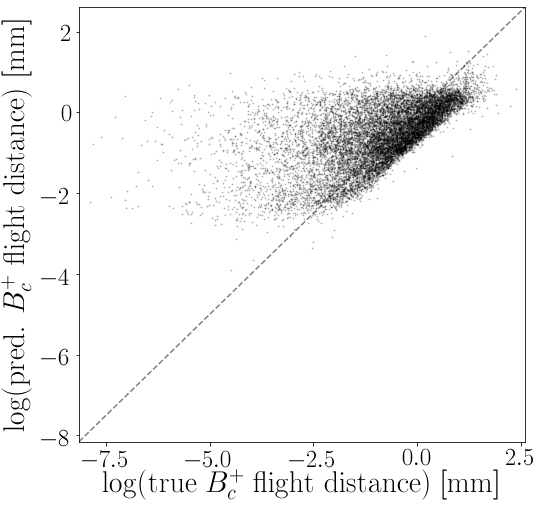

In [81]:
fig,ax = plt.subplots(figsize=(8,8))
val_min = np.min(df_sig["log_PVsep_parent"])*0.9
val_max = np.max(df_sig["log_PVsep_parent"])*1.1
plt.scatter(df_sig["log_PVsep_parent"],df_sig["log_pred_PVsep_parent"],color='k',s=1,alpha=0.2)
plt.ylim(val_min,val_max)
plt.xlim(val_min,val_max)
xvals = np.linspace(val_min, val_max, 1000)
plt.plot(xvals,xvals,color="k",linestyle="--",alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel("log(true $B_c^+$ flight distance) [mm]",fontsize=30)
plt.ylabel("log(pred. $B_c^+$ flight distance) [mm]",fontsize=30)
plt.show()

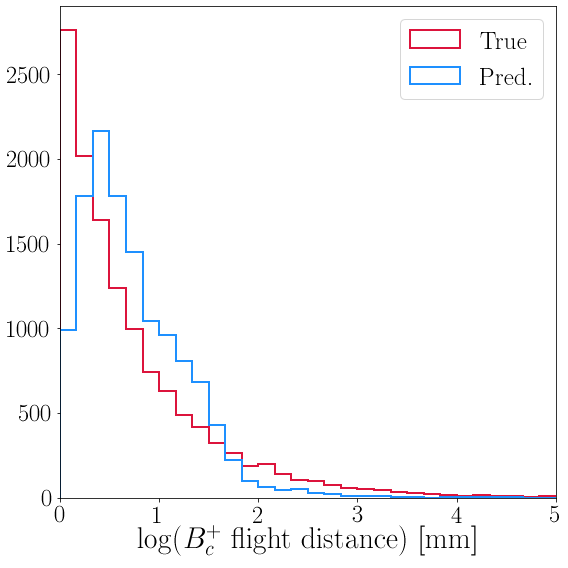

In [82]:
fig,ax = plt.subplots(figsize=(8,8))
val_min = 0.
val_max = 5.
plt.hist(df_sig["PVsep_parent"],bins=30,range=(val_min,val_max),color='crimson',histtype='step',linewidth=2,label="True")
plt.hist(df_sig["pred_PVsep_parent"],bins=30,range=(val_min,val_max),color='dodgerblue',histtype='step',linewidth=2,label="Pred.")
plt.xlim(val_min,val_max)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel("log($B_c^+$ flight distance) [mm]",fontsize=30)
plt.legend(fontsize=25)
plt.tight_layout()
plt.show()

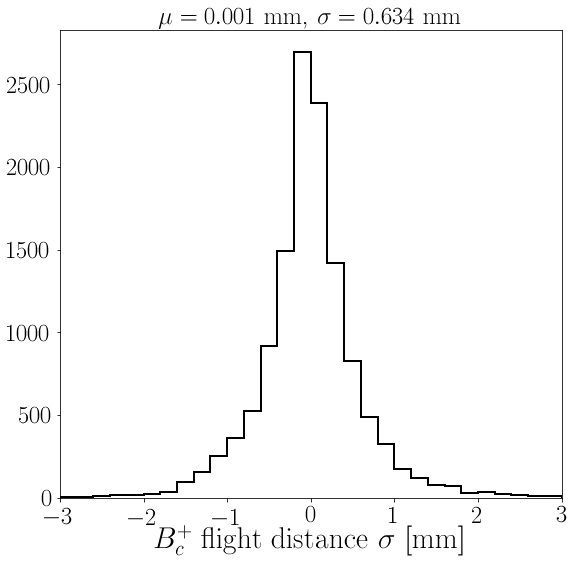

In [83]:
#Plot flight resolution
df_sig["PVsep_parent_res"] = df_sig["PVsep_parent"] - df_sig["pred_PVsep_parent"]
df_sig["PVsep_parent_res_per"] = df_sig["PVsep_parent_res"]/df_sig["PVsep_parent"]
mu = df_sig["PVsep_parent_res"].mean()
sigma = df_sig["PVsep_parent_res"].std()
fig,ax = plt.subplots(figsize=(8,8))
val_min = -3.
val_max = 3.
plt.hist(df_sig["PVsep_parent_res"],bins=30,range=(val_min,val_max),color='k',histtype='step',linewidth=2)
plt.xlim(val_min,val_max)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel("$B_c^+$ flight distance $\sigma$ [mm]",fontsize=30)
plt.title("$\mu = %.3f$ mm, $\sigma = %.3f$ mm" % (mu,sigma),fontsize=25)
plt.tight_layout()
plt.show()